# Introduction

Validating EBDC online compression throughput using the Supermicro SuperWorkstation 7049GP-TRT, with 2 x Intel Xeon Silver 4216 Processor 16-Core 2.1GHz 32 core CPUs and 128 GB memory. 

The data is all 2019 sPHENIX TPC SAMPA data at FTBF total 1+TB. The data are buffered on ASUS Hyper M.2 X16 PCIe 3.0 X4 Expansion Card V2 with four SAMSUNG 970 EVO PLUS M.2 2280 1TB PCIe Gen 3.0 x4 NVMe 1.3 V-NAND configured in 4-strip software RAID0. The RAID is tested to 6GBps write and 11GBps write through its PCIe Gen3 x16 interface, matching a large fraction of the FELIX throughput and suppass the expected average rate in sPHENIX year-5 operation. 

The data is readout as `parallel` jobs via [start-compression.sh](/start-compression.sh), and sink via either `/dev/null` or TPC connections to multiple `ncat` processes either at `localhost` or remote which can be started with [start-sink.sh](/start-sink.sh)

# Inputs

In [1]:
# DataDir = './data_tmp/'
# DataDir = './data_25x_localhost/'
# DataDir = './data_48x_localhost/'
# studytitle = r"$\bf{EBDC}$" + " compression\nlocalhost loopback"
DataDir = './data_48x_null/'
studytitle = r"$\bf{EBDC}$" + " compression\noutput to /dev/null"

In [2]:
# %matplotlib widget
# %matplotlib ipympl
%matplotlib inline  
# well the html export like dump formats

# Processing

In [3]:
import os
import ntpath
import re
import pandas as pd
import numpy as np


def processDataset(dataset: str):    
    split = dataset.split('-')
    if (len(split) != 3):
        print('skip {}'.format (dataset) );
        return;
    
    zipcmd = split[0];
    ziplevel = int(split[1]);
    jobs = int(split[2]);
    datasetDir = os.path.join(DataDir, dataset)
        
    print('processing {}, {} level{} x{}'.format (datasetDir, zipcmd,ziplevel,jobs) );

    datasubfolders = [os.path.basename(f.path) for f in os.scandir(datasetDir) if f.is_file() ]
    datasubfolders.sort()
    rpv_in = re.compile('pv_in_([0-9]*)\.log')

    for data in datasubfolders:
#         print ('data = {}'.format(data));
        m = rpv_in.search(data)
        if m is not None:
#             print ('found {} -> {}'.format(data, m.group(1)));
            jobID = m.group(1);
            with open(os.path.join(datasetDir, 'pv_in_{}.log'.format(jobID))) as f:
                split = f.readlines()[-1].split();
                assert(len(split)==2)
                inTime = float(split[0])
                inSize = float(split[1])
            with open(os.path.join(datasetDir, 'pv_out_{}.log'.format(jobID))) as f:
                split = f.readlines()[-1].split();
                assert(len(split)==2)
                outTime = float(split[0])
                outSize = float(split[1])
            
#             print ('df.append {} . {} , {} -> {}'.format(data, jobID,inSize,outSize));
            dictData = { 'dataset' : dataset ,
                      'zipcmd': zipcmd,
                      'ziplevel': ziplevel,
                      'jobs': jobs,
                      'jobID': jobID,
                      'inTime': inTime,
                      'inSize': inSize,
                      'outTime': outTime  ,
                      'outSize': outSize                                        
                      } 
            global dataframe
            dataframe = dataframe.append(dictData, ignore_index=True) 



dataframe = pd.DataFrame(columns=['dataset', 'zipcmd', 'ziplevel', 'jobs', 'jobID', 'inTime', 'inSize', 'outTime', 'outSize'])
subfolders = [f.path for f in os.scandir(DataDir) if f.is_dir() ]
subfolders.sort()

for dataset in subfolders:
    processDataset(os.path.basename(dataset))



processing ./data_48x_null/gzip-1-48, gzip level1 x48
processing ./data_48x_null/gzip-2-48, gzip level2 x48
processing ./data_48x_null/gzip-3-48, gzip level3 x48
processing ./data_48x_null/gzip-5-48, gzip level5 x48
processing ./data_48x_null/gzip-7-48, gzip level7 x48
processing ./data_48x_null/gzip-9-48, gzip level9 x48
processing ./data_48x_null/lz4-1-48, lz4 level1 x48
processing ./data_48x_null/lz4-2-48, lz4 level2 x48
processing ./data_48x_null/lz4-3-48, lz4 level3 x48
processing ./data_48x_null/lz4-5-48, lz4 level5 x48
processing ./data_48x_null/lz4-7-48, lz4 level7 x48
processing ./data_48x_null/lz4-9-48, lz4 level9 x48
processing ./data_48x_null/lzop-1-48, lzop level1 x48
processing ./data_48x_null/lzop-2-48, lzop level2 x48
processing ./data_48x_null/lzop-3-48, lzop level3 x48
processing ./data_48x_null/lzop-5-48, lzop level5 x48
processing ./data_48x_null/lzop-7-48, lzop level7 x48
processing ./data_48x_null/lzop-9-48, lzop level9 x48


# Plot

In [4]:
dataframeSum = pd.DataFrame(columns=['dataset', 'zipcmd', 'ziplevel', 'jobs','totalInTime', 'totalInSize', 'totalOutTime', 'totalOutSize', 'Compression', 'inRateGbps', 'outRateGbps'])

zipcmds = dataframe.zipcmd.unique()

for zipcmd in zipcmds:
    
    zipRows = dataframe.loc[dataframe['zipcmd'] == zipcmd]
    
    ziplevels = zipRows.ziplevel.unique()
    for ziplevel in ziplevels:
        ziplevelRows = zipRows.loc[zipRows['ziplevel'] == ziplevel]
        print ('processing ', zipcmd, '.',ziplevel, ' size= ',ziplevelRows.size, 'compression ratio = ',ziplevelRows['outSize'].sum()/ziplevelRows['inSize'].sum())
        assert(ziplevelRows.size>1000)
                
        dictData = { 'dataset' : ziplevelRows['dataset'].iloc[0] ,
                  'zipcmd':  ziplevelRows['zipcmd'].iloc[0] ,
                  'ziplevel':  ziplevelRows['ziplevel'].iloc[0] ,    
                  'jobs':  ziplevelRows['jobs'].iloc[0] , 
                    'totalInTime' : ziplevelRows['inTime'].sum() ,
                  'totalInSize':  ziplevelRows['inSize'].sum() ,
                  'totalOutTime':  ziplevelRows['outTime'].sum() ,    
                  'totalOutSize':  ziplevelRows['outSize'].sum() ,
                    
                  } 
        
        dictData['Compression'] = dictData['totalOutSize']/ dictData['totalInSize']
        dictData['inRateGbps'] = dictData['totalInSize']/ dictData['totalInTime'] * dictData['jobs'] *8/1e9
        dictData['outRateGbps'] = dictData['totalOutSize']/ dictData['totalOutTime']* dictData['jobs'] *8/1e9
    
        dataframeSum = dataframeSum.append(dictData, ignore_index=True) 

processing  gzip . 1  size=  2133 compression ratio =  0.43932139377897234
processing  gzip . 2  size=  2133 compression ratio =  0.43639353842830403
processing  gzip . 3  size=  2133 compression ratio =  0.424364599250152
processing  gzip . 5  size=  2133 compression ratio =  0.4300136029630121
processing  gzip . 7  size=  2133 compression ratio =  0.4264271430634125
processing  gzip . 9  size=  2133 compression ratio =  0.42370792929411943
processing  lz4 . 1  size=  2133 compression ratio =  0.6751259046982664
processing  lz4 . 2  size=  2133 compression ratio =  0.6751259046982664
processing  lz4 . 3  size=  2133 compression ratio =  0.5778558660340661
processing  lz4 . 5  size=  2133 compression ratio =  0.5365085644373812
processing  lz4 . 7  size=  2133 compression ratio =  0.5207546008082999
processing  lz4 . 9  size=  2133 compression ratio =  0.5189943751016245
processing  lzop . 1  size=  2133 compression ratio =  0.6377294848760965
processing  lzop . 2  size=  2133 compress

In [5]:

import matplotlib.pyplot as plt
import numpy as np

Colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF']
Markers = ['o' , 's',  'D','p' , 'P']

font = {'size'   : 14}
plt.rcdefaults()
plt.rc('font', **font)

studytitle_sup = studytitle + "\n{:d} proc. 2x Xeon4216\n{:.1f}TB TPC FTBF data".format(
    dataframeSum['jobs'].iloc[0], dataframeSum['totalInSize'].iloc[0]/1e12)

## Compression plot

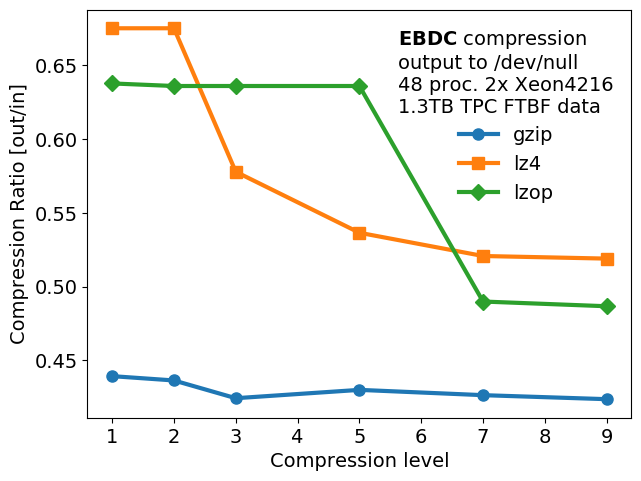

In [6]:

# dataframeSum.plot(x = 'ziplevel', y = "Compression")

fig = plt.figure()
ax = fig.add_axes([0.15, 0.15, 0.85, 0.85])
plt.xlabel('Compression level')
plt.ylabel('Compression Ratio [out/in]')

markiter = iter(Markers);
coleriter = iter(Colors);

for zipcmd in dataframeSum.zipcmd.unique():    
    zipRows = dataframeSum.loc[dataframeSum['zipcmd'] == zipcmd]
    ax.plot(zipRows['ziplevel'].to_numpy(), zipRows['Compression'].to_numpy(),
            marker=next(markiter), color=next(coleriter), markersize = 8, linewidth = 3,
            label=zipcmd)
    
plt.legend(loc='best',title = studytitle_sup, frameon=False)

plt.savefig(os.path.join(DataDir,"Compression.png"), dpi=150)
plt.savefig(os.path.join(DataDir,"Compression.pdf"), dpi=150)


## Compressed throughput

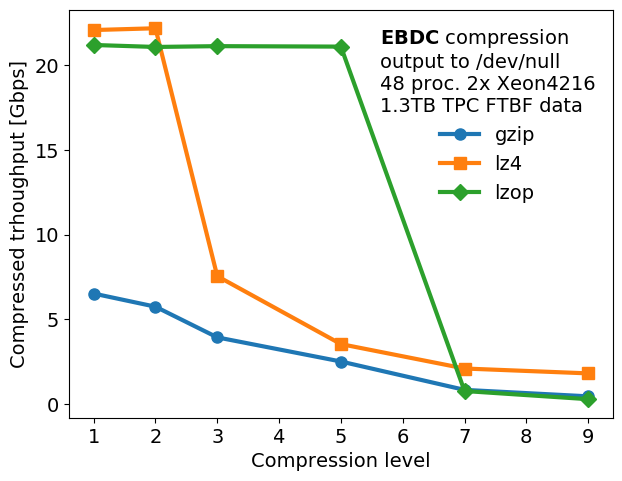

In [7]:
# dataframeSum.plot(x = 'ziplevel', y = "Compression")

fig = plt.figure()
ax = fig.add_axes([0.15, 0.15, 0.85, 0.85])
plt.xlabel('Compression level')
plt.ylabel('Compressed trhoughput [Gbps]')

markiter = iter(Markers);
coleriter = iter(Colors);

for zipcmd in dataframeSum.zipcmd.unique():    
    zipRows = dataframeSum.loc[dataframeSum['zipcmd'] == zipcmd]
    ax.plot(zipRows['ziplevel'].to_numpy(), zipRows['outRateGbps'].to_numpy(),
            marker=next(markiter), color=next(coleriter), markersize = 8, linewidth = 3,
            label=zipcmd)
    
plt.legend(loc='best',title = studytitle_sup, frameon=False)

plt.savefig(os.path.join(DataDir,"Throughput.png"), dpi=150)
plt.savefig(os.path.join(DataDir,"Throughput.pdf"), dpi=150)

## Work point curve

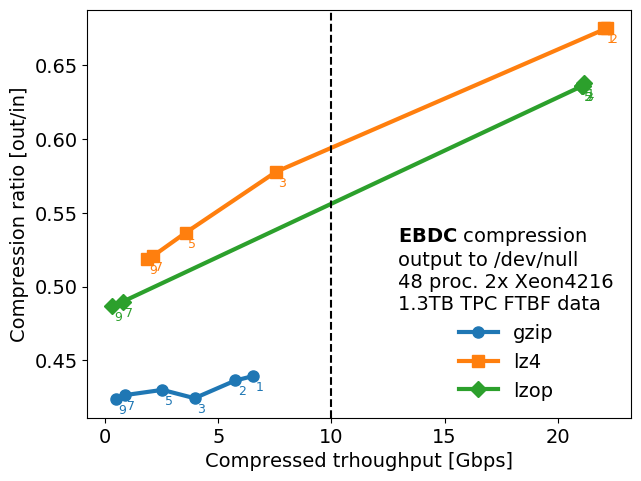

In [8]:
# dataframeSum.plot(x = 'ziplevel', y = "Compression")

fig = plt.figure()
ax = fig.add_axes([0.15, 0.15, 0.85, 0.85])
plt.ylabel('Compression ratio [out/in]')
plt.xlabel('Compressed trhoughput [Gbps]')

markiter = iter(Markers);
coleriter = iter(Colors);

for zipcmd in dataframeSum.zipcmd.unique():    
    zipRows = dataframeSum.loc[dataframeSum['zipcmd'] == zipcmd]
    outRateGbps = zipRows['outRateGbps'].to_numpy()
    Compression = zipRows['Compression'].to_numpy()
    ziplevel = zipRows['ziplevel'].to_numpy()
    c = next(coleriter)
    ax.plot(outRateGbps, Compression,
            marker=next(markiter), color=c, markersize = 8, linewidth = 3,
            label=zipcmd)
    
    for i in range(0, len(outRateGbps)):
        plt.text(outRateGbps[i]+.1, Compression[i]-.01,str(ziplevel[i]), fontsize=9, color=c)
    
#              [str(i) for i in zipRows['ziplevel'].to_numpy()], fontsize=9)
    
ax.add_line(plt.Line2D([10, 10],ax.get_ylim(), color = 'black', linestyle = '--'))

plt.legend(loc='best',title = studytitle_sup,
           edgecolor = 'white', frameon=True, facecolor='white', framealpha=0.9)

plt.savefig(os.path.join(DataDir,"FOM.png"), dpi=150)
plt.savefig(os.path.join(DataDir,"FOM.pdf"), dpi=150)

# Scratch

In [9]:
# %save_html os.path.join(DataDir,"analysis.html")
import sys
from subprocess import check_call

d, fname = os.path.split(sys.executable)
# print (d,fname)
check_call([os.path.join(d,'ipython'), 'nbconvert',
            '--to', 'html',
            'RateAnalysis.ipynb',
            '--output',
            os.path.join(DataDir,"analysis.html")])
check_call([os.path.join(d,'ipython'), 'nbconvert',
            '--to', 'pdf',
            'RateAnalysis.ipynb',
            '--output',
            os.path.join(DataDir,"analysis.pdf")])



0

In [10]:
dataframeSum

,dataset,zipcmd,ziplevel,jobs,totalInTime,totalInSize,totalOutTime,totalOutSize,Compression,inRateGbps,outRateGbps
0,gzip-1-48,gzip,1,48,34777.5720,1.345599e+12,34778.0978,5.911506e+11,0.439321,14.857569,6.527149
1,gzip-2-48,gzip,2,48,39200.0298,1.345599e+12,39200.6254,5.872109e+11,0.436394,13.181372,5.752178
2,gzip-3-48,gzip,3,48,55600.9075,1.345599e+12,55601.6721,5.710247e+11,0.424365,9.293197,3.943649
3,gzip-5-48,gzip,5,48,88135.3297,1.345599e+12,88136.4849,5.786260e+11,0.430014,5.862691,2.521004
4,gzip-7-48,gzip,7,48,259775.3715,1.345599e+12,259778.4646,5.738001e+11,0.426427,1.989065,0.848181
5,gzip-9-48,gzip,9,48,468696.6342,1.345599e+12,468702.2151,5.701411e+11,0.423708,1.102441,0.467107
6,lz4-1-48,lz4,1,48,15807.7117,1.345599e+12,15811.1099,9.084490e+11,0.675126,32.687221,22.063246
7,lz4-2-48,lz4,2,48,15733.1171,1.345599e+12,15736.5150,9.084490e+11,0.675126,32.842199,22.167832
8,lz4-3-48,lz4,3,48,39522.0082,1.345599e+12,39534.2531,7.775625e+11,0.577856,13.073985,7.552539
9,lz4-5-48,lz4,5,48,78112.7323,1.345599e+12,78137.2279,7.219256e+11,0.536509,6.614929,3.547853
